In [1]:
from lifelines.statistics    import logrank_test
from lifelines.utils         import concordance_index
from sksurv.metrics          import concordance_index_censored
from matplotlib.colors       import LinearSegmentedColormap
from matplotlib.colors       import TwoSlopeNorm
from matplotlib.pyplot       import rc_context
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.transform       import resize
from scipy.cluster           import hierarchy
from plottify                import autosize
from PIL                     import Image
from scipy.stats             import combine_pvalues
from collections             import OrderedDict
from adjustText              import adjust_text
from matplotlib              import ticker
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import seaborn           as sns
import numpy             as np
import pandas            as pd
import scanpy            as sc
import matplotlib
import fastcluster
import pickle
import anndata
import random
import umap
import h5py
import copy
import sys
import os

main_path = '/media/adalberto/Disk2/PhD_Workspace'
sys.path.append(main_path)
from models.clustering.cox_proportional_hazard_regression_leiden_clusters import *
from models.clustering.logistic_regression_leiden_clusters                import *
from models.visualization.survival                                        import save_fold_KMs
from models.visualization.clusters                                        import cluster_circular, plot_confusion_matrix_lr
from models.visualization.forest_plots                                    import report_forest_plot_lr
from models.evaluation.folds                                              import load_existing_split
from data_manipulation.data                                               import Data
from models.clustering.correlations      import *
from models.clustering.data_processing   import *
from models.visualization.attention_maps import *


/home/adalberto/.local/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


# Figure method

## Visualization methods

In [2]:
def plot_institution_distribution(data_hpc_inst, field, title, figsize=(30,7), fontsize_labels=22, fontsize_legend=20, show_max_min=False):
    def colors_from_values(values, palette_name, normalize=False):
        # normalize the values to range [0, 1]
        if normalize:
            normalized = (values - min(values)) / (max(values) - min(values))
        else:
            normalized = values
        # convert to indices
        indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
        # use the indices to get the colors
        palette = sns.color_palette(palette_name, int(1.5*len(values)))
        return np.array(palette).take(indices, axis=0)

    fig   = plt.figure(figsize=figsize)
    ax    = fig.add_subplot(1, 1, 1)

    # pal  = sns.color_palette("Greens_d")
    # rank = data_hpc_inst[field].argsort().argsort()
    # sns.barplot(data=data_hpc_inst, x='HPC', y=field, palette=np.array(pal[::-1])[rank], ax=ax)

    y = data_hpc_inst[field].values
    sns.barplot(data=data_hpc_inst, x='HPC', y=field, palette=colors_from_values(y, "Greens_d"), ax=ax)

    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0.0,1.0])
    yticks = (np.array(range(0,11,1))/10).tolist()
    ax.set_yticks(yticks, yticks)

    ax.set_title(title,  fontsize=fontsize_labels*1.3, fontweight='bold')
    ax.set_xlabel('\nHistomorphological Phenotype Cluster (HPC)', fontsize=fontsize_labels,     fontweight='bold')
    ax.set_ylabel(' ', fontsize=fontsize_labels, fontweight='bold')
    if show_max_min:
        max_val = np.max(data_hpc_inst[field].values)
        min_val = np.min(data_hpc_inst[field].values)
        ax.axhline(max_val, linestyle='--')
        ax.axhline(min_val, linestyle='--')
    ax.axhline(0.50, linestyle='--', color='black')
    ax.axhline(0.25, linestyle='--', color='black')

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_labels)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_labels)
        tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    plt.show()

def get_col_colors(cox_os_clusters, cox_pfs_clusters, immune_hot_clusters, p_th):

    colors        = []
    colors_masked = []

    if immune_hot_clusters is not None:
        cmap_PiYG = sns.diverging_palette(20, 250, as_cmap=True)
        norm      = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
        immune_clusters = [1]*cox_pfs_clusters.shape[0]
        for key in immune_hot_clusters:
            if key == 'hot':
                value = -1
            elif key == 'warm':
                value = -0.5
            elif key == 'cold':
                value = 0
            for cluster in immune_hot_clusters[key]:
                immune_clusters[cluster] = value
        column_immune_colors       = pd.Series([cmap_PiYG(norm(coef)) for cluster, coef in enumerate(immune_clusters)], name='Hot/Warm/Cold Lymphocytic Infiltration')
        if cox_os_clusters is not None:
            coef_df          = cox_os_clusters.sort_values(by=groupby)
            column_immune_colors.index = coef_df[groupby].astype(str)
        else:
            column_immune_colors.index = column_immune_colors.index.astype(str)
        colors.append(column_immune_colors)
        colors_masked.append(column_immune_colors)

    # Column colors.
    if cox_os_clusters is not None:
        coef_df   = cox_os_clusters.sort_values(by=groupby)
        cmap_PiYG = plt.cm.PiYG_r
        norm      = TwoSlopeNorm(vmin=coef_df['coef'].min(), vcenter=0, vmax=coef_df['coef'].max())
        column_os_colors              = pd.Series([cmap_PiYG(norm(coef)) for p, coef in zip(coef_df['p'], coef_df['coef'])], name='Cox Coefficient OS')
        column_os_colors_masked       = pd.Series([cmap_PiYG(norm(coef)) if p <p_th else cmap_PiYG(norm(0))[:3] for p, coef in zip(coef_df['p'], coef_df['coef'])], name='Cox Coefficient OS')
        column_os_colors_masked.index = coef_df[groupby].astype(str)
        column_os_colors.index        = coef_df[groupby].astype(str)
        colors.append(column_os_colors)
        colors_masked.append(column_os_colors_masked)

    if cox_pfs_clusters is not None:
        cox_pfs_clusters = cox_pfs_clusters.sort_values(by=groupby)
        cmap_PiYG = plt.cm.PiYG_r
        norm                     = TwoSlopeNorm(vmin=cox_pfs_clusters['coef'].astype(float).min(), vcenter=0, vmax=cox_pfs_clusters['coef'].astype(float).max())
        column_pfs_colors        = pd.Series([cmap_PiYG(norm(coef)) for p, coef in zip(cox_pfs_clusters['p'], cox_pfs_clusters['coef'])], name='Cox Coefficient RFS')
        column_pfs_colors_masked = pd.Series([cmap_PiYG(norm(coef)) if p <p_th else cmap_PiYG(norm(0))[:3] for p, coef in zip(cox_pfs_clusters['p'], cox_pfs_clusters['coef'])], name='Cox Coefficient RFS')
        column_pfs_colors.index        = coef_df[groupby].astype(str)
        column_pfs_colors_masked.index = coef_df[groupby].astype(str)
        colors.append(column_pfs_colors)
        colors_masked.append(column_pfs_colors)

    if len(colors) != 0:
        colors = pd.concat(colors,axis=1)
        colors_masked = pd.concat(colors_masked,axis=1)
    else:
        colors        = None
        colors_masked = None

    return colors, colors_masked

def fixedWidthClusterMap(dataFrame, mask, x_label, y_label, vcenter=0, annot=True, fmt='.2f', col_linkage=None, row_linkage=None, 
                        fontsize_ticks=28, fontsize_labels=30, fontsize_annot=20, dendrogram_ratio=0.2, 
                        immune_hot_clusters=None, cox_os_clusters=None, cox_pfs_clusters=None, 
                        cellSizePixels_x=50, cellSizePixels_y=50, p_th=0.05, offset_col_color=2, 
                        resize_col_den=1.0, linewidths=5.0, row_cluster=True, col_cluster=True, round_cbar=2, cmap=sns.diverging_palette(250, 20, as_cmap=True)):
    sns.set_theme(style='white')

    colors, colors_masked = get_col_colors(cox_os_clusters, cox_pfs_clusters, immune_hot_clusters, p_th)

    # Calculate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams['figure.dpi']
    marginWidth  = (matplotlib.rcParams['figure.subplot.right']-matplotlib.rcParams['figure.subplot.left'])
    marginHeight = (matplotlib.rcParams['figure.subplot.top']-matplotlib.rcParams['figure.subplot.bottom'])
    Ny,Nx = dataFrame.shape
    figWidth = (Nx*cellSizePixels_x/dpi)/0.8/marginWidth
    figHeigh = ((Ny+offset_col_color)*cellSizePixels_y/dpi)/0.8/marginHeight

    # do the actual plot
    vmax = np.nanmax(dataFrame[~mask].values)
    if vcenter == 0:
        vmin = -vmax
        cbar_kws = dict()
    else:
        vmin = np.nanmin(dataFrame[~mask].values)
        ticks = np.array([vmin*1.01, (vmin+vcenter)/2, vcenter, (vmax+vcenter)/2, vmax*0.99])
        ticks = np.round(ticks, round_cbar)
        cbar_kws = dict(ticks=ticks)

    if col_linkage is None and col_cluster:
        Z = hierarchy.linkage(y=dataFrame.T, method='ward', metric='euclidean', optimal_ordering=True)
        col_linkage = Z

    if row_linkage is None and col_cluster:
        Z = hierarchy.linkage(y=dataFrame, method='ward', metric='euclidean', optimal_ordering=True)
        row_linkage = Z

    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    grid = sns.clustermap(dataFrame, vmin=vmin, vmax=vmax, method='ward', metric='euclidean', annot=annot, mask=mask, col_linkage=col_linkage, row_linkage=row_linkage, fmt=fmt, col_colors=colors, tree_kws=dict(linewidths=linewidths), norm=norm,
                          cmap=cmap, dendrogram_ratio=dendrogram_ratio, annot_kws={"size": fontsize_annot,'fontstyle':'italic','fontweight':'bold'},  yticklabels=True,  xticklabels=True,
                          row_cluster=row_cluster, col_cluster=col_cluster, figsize=(figWidth, figHeigh), cbar_kws=cbar_kws)

    if colors is not None:
        grid.ax_col_colors.set_yticklabels(grid.ax_col_colors.get_ymajorticklabels(), fontsize=fontsize_ticks)

    # calculate the size of the heatmap axes
    axWidth  = (Nx*cellSizePixels_x)/(figWidth*dpi)
    axHeight = (Ny*cellSizePixels_y)/(figHeigh*dpi)

    # calculate size of column colors
    ax_colors_height = (offset_col_color*cellSizePixels_y)/(figWidth*dpi)

    # resize heatmap
    ax_heatmap_orig_pos = grid.ax_heatmap.get_position()
    grid.ax_heatmap.set_position([ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight])

    # resize row dendrogram to match
    ax_row_orig_pos = grid.ax_row_dendrogram.get_position()
    grid.ax_row_dendrogram.set_position([ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight])

    # resize col_colors
    if colors is not None:
        ax_col_colors_orig_pos = grid.ax_col_colors.get_position()
        grid.ax_col_colors.set_position([ax_col_colors_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight+0.01, axWidth, ax_colors_height])

    # resize col dendrogram to match
    ax_col_orig_pos = grid.ax_col_dendrogram.get_position()
    grid.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight+ax_colors_height+0.01, axWidth, ax_col_orig_pos.height*resize_col_den])

    # tick_locator = ticker.MaxNLocator(nbins=cbar_bins)
    # grid.ax_cbar.cla.locator = tick_locator
    # grid.ax_cbar.cla.update_ticks()

    ax_cbar_orig_pos = grid.ax_cbar.get_position()
    grid.ax_cbar.set_position([ax_row_orig_pos.x0+ax_row_orig_pos.width*0.25, ax_heatmap_orig_pos.y0+axHeight, ax_row_orig_pos.width*0.25, ax_col_orig_pos.height*resize_col_den])

    grid.ax_cbar.tick_params(labelsize=fontsize_ticks*0.9, length=10)
    [label.set_fontweight('bold') for label in grid.ax_cbar.get_yticklabels()]

    grid.ax_heatmap.set_xlabel('\n%s' % x_label, fontsize=fontsize_labels, fontweight='bold')
    grid.ax_heatmap.set_ylabel('\n%s' % y_label, fontsize=fontsize_labels, fontweight='bold')

    grid.ax_heatmap.set_xticklabels(grid.ax_heatmap.get_xmajorticklabels(), fontsize=fontsize_ticks, weight='bold')
    grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_ymajorticklabels(), fontsize=fontsize_ticks, weight='bold', rotation=0)

    if colors is not None:
        [label.set_fontweight('bold') for label in grid.ax_col_colors.get_yticklabels()]

    for axis in ['top','bottom','left','right']:
        grid.ax_heatmap.spines[axis].set_linewidth(4)

    return grid # return ClusterGrid object

def show_correlation_scatter(cross_df, cluster, annotations, all_data_rho, all_data_pval, fontsize_labels=22, fontsize_title=30):
    from decimal import Decimal
    cross_df.columns = cross_df.columns.astype(str)

    for i, annotation in enumerate(annotations):
        rho_annotation  = all_data_rho.loc[annotation, str(cluster)]
        pval_annotation = all_data_pval.loc[annotation, str(cluster)]
        g = sns.jointplot(data=cross_df, x=annotation, y=str(cluster), kind='reg', ci=None, height=10, ratio=2)
        g.ax_joint.set_ylabel('HPC %s\nContribution' % cluster, fontsize=fontsize_labels, fontweight='bold')
        g.ax_joint.set_xlabel(annotation, fontsize=fontsize_labels, fontweight='bold')

        for tick in g.ax_joint.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_labels)
            tick.label1.set_fontweight('bold')
        for tick in g.ax_joint.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_labels)
            tick.label1.set_fontweight('bold')

        for axis in ['top','bottom','left','right']:
            g.ax_joint.spines[axis].set_linewidth(4)
            g.ax_marg_x.spines[axis].set_linewidth(4)
            g.ax_marg_y.spines[axis].set_linewidth(4)

        plt.suptitle('Spearman %s=%s\np-value=%s' % (r'$\mathbf{\rho}$', np.round(rho_annotation, 1), '%.1E' % Decimal(pval_annotation)), fontsize=fontsize_title, fontweight='bold')
        g.fig.tight_layout()
        plt.show()

def relplot_figure(data, x, y, hue, col_wrap, col, col_order, size, pval_th, sizes=(10, 100), height=3, aspect=3.5, facet_kws={'sharex': False, 'sharey': True}):

    g = sns.relplot(data=data, y=y, x=x, hue=hue, col_wrap=col_wrap, col=col, col_order=col_order, size=size, sizes=sizes, height=height, aspect=aspect, facet_kws=facet_kws)
    i = 0
    for ax in g._axes:
        ann = ax.get_title().split('%s = ' % col)[1]
        data_imm = data[data[col]==ann]
        order_hpc = data_imm.groupby(by='HPC').mean().sort_values(by='Rho').index.tolist()
        ax.set_ylim([-0.5, 0.8])
        for tick in ax.xaxis.get_major_ticks():
            label = tick.label1
            if label._text in data_imm[data_imm['HPC']==label._text]['HPC'].values.astype(str):
                p_val = data_imm[(data_imm['HPC']==label._text)]['P-Value Combined'].values[0]
                if p_val < pval_th:
                    label.set_fontsize(label._fontproperties._size*1.2)
                    label.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontweight('bold')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
        ax.tick_params(axis='x', rotation=45)
        ax_title = ax.title._text.replace('= ', '')
        ax.set_title(ax_title, fontsize=ax.title._fontproperties._size*1.3, fontweight='bold')
        ax.set_xlabel(ax.get_xlabel(), fontsize=ax.title._fontproperties._size, fontweight='bold')
        if i%col_wrap == 0:
            ax.set_ylabel(r'$\mathbf{\rho}$', fontsize=ax.title._fontproperties._size, fontweight='bold')
        i += 1
        ax.axhline(0.0, linestyle='--', color='grey', lw=1)
        ax.set_title(ann, fontsize=ax.title._fontproperties._size*1.2, fontweight='bold', y=0.9)

    g._legend.get_title().set_weight('bold')
    [leg_text.set_weight('bold') for leg_text in g._legend.get_texts()]
    plt.show()

    return g


## Combine correlations Pan-Cancer

In [3]:
# Filter out immune feature with low number of significant correlations.
def keep_features_min_corr(mask, data, keep_th):
    data_plot = data.copy(deep=True)
    mask_plot = mask.copy(deep=True)

    mask_plot_th = (~mask_plot).sum(axis=1)
    subset_features = mask_plot_th[mask_plot_th>=keep_th].index

    return data_plot.loc[subset_features], mask_plot.loc[subset_features]

def clean_correlation(all_data_rho, all_data_pval, all_data_samples, mask, th_corr, remove_nan=False):
    # Remove row and columns with all non-significant
    if th_corr>0:
        remove_empty_row = mask[np.sum(~mask,axis=1)<=th_corr].index
        remove_empty_col = mask.columns[np.sum(~mask,axis=0)<=th_corr].tolist()
        all_data_rho      = all_data_rho.drop(index=remove_empty_row)
        all_data_rho      = all_data_rho.drop(columns=remove_empty_col)
        all_data_pval     = all_data_pval.drop(index=remove_empty_row)
        all_data_pval     = all_data_pval.drop(columns=remove_empty_col)
        all_data_samples  = all_data_samples.drop(index=remove_empty_row)
        all_data_samples  = all_data_samples.drop(columns=remove_empty_col)
        mask              = mask.drop(index=remove_empty_row)
        mask              = mask.drop(columns=remove_empty_col)

    # Remove row and columns with all nan
    if remove_nan:
        remove_empty_row = all_data_rho[np.sum(~(all_data_rho.isnull()),axis=1)==0].index
        # remove_empty_col = all_data_rho.columns[np.sum(~(all_data_rho.isnull()),axis=0)==0].tolist()
        all_data_rho      = all_data_rho.drop(index=remove_empty_row)
        all_data_pval     = all_data_pval.drop(index=remove_empty_row)
        all_data_samples  = all_data_samples.drop(index=remove_empty_row)
        mask              = mask.drop(index=remove_empty_row)

    return all_data_rho, all_data_pval, all_data_samples, mask

def combine_correlations_multiple(correlation_data, shape, labels_consider, type_integration='weighted_average', pval_th=0.01, method_comb_pval='fisher', th_corr=0, remove_nan=False):
    all_data_rho     = np.zeros(shape)
    all_data_pval    = np.ones(shape)
    all_data_samples = np.zeros(shape)

    for row in range(shape[0]):
        for column in range(shape[1]):
            weights = [correlation_data[label][2].values[row,column].astype(int) for label in labels_consider]
            if 'weighted_average'==type_integration:
                all_data_rho[row,column]     = np.average([correlation_data[label][0].values[row,column] for label in labels_consider], weights=weights)
            else:
                all_data_rho[row,column]     = np.mean([correlation_data[label][0].values[row,column] for label in labels_consider])
            all_data_pval[row,column]    = combine_pvalues([correlation_data[label][1].values[row,column] for label in labels_consider], method=method_comb_pval)[1]
            all_data_samples[row,column] = np.mean([correlation_data[label][2].values[row,column] for label in labels_consider])

    label = labels_consider[0]
    all_data_rho           = pd.DataFrame(all_data_rho, columns=correlation_data[label][0].columns)
    all_data_rho.index     = correlation_data[label][0].index

    all_data_pval          = pd.DataFrame(all_data_pval, columns=correlation_data[label][0].columns)
    all_data_pval.index    = correlation_data[label][0].index

    all_data_samples       = pd.DataFrame(all_data_samples, columns=correlation_data[label][0].columns)
    all_data_samples.index = correlation_data[label][0].index

    mask = (all_data_pval.values > pval_th)
    mask = pd.DataFrame(mask, columns=correlation_data[label][0].columns)
    mask.index = correlation_data[label][0].index

    return all_data_rho, all_data_pval, all_data_samples, mask


    # Run correlation per label

def correlations_across_types(slide_rep_df, annotations_df, meta_field, groupby, fold_number, pval_th, file_name, directory, matching_field='samples', corr_method='spearman', method_comb_pval='fisher', type_integration='weighted_average',
                              th_corr=0, remove_nan=False):
    # All available fields.
    annotation_fields = [annotation for annotation in immune_landscape_df.columns if annotation not in ['slides', matching_field]]

    # Get labels that have annotations for all fields.
    merged_df     = slide_rep_df.merge(annotations_df, how='inner', left_on=matching_field, right_on=matching_field)
    labels_allann = merged_df[~(merged_df[annotation_fields].isnull()).any(axis=1)].labels.unique()

    # Correlation all types combined.
    final_dict = dict()
    all_data_rho_clr, all_data_pval_clr, all_data_samples_clr, mask_clr, _ = correlate_clusters_annotation(slide_rep_df=slide_rep_df, annotations_df=annotations_df, purity_field=meta_field,
                                                                                                       matching_field=matching_field, corr_method=corr_method, pval_th=pval_th, field_th=None,
                                                                                                       groupby=groupby, fold_number=fold_number, directory=directory, file_name=None)
    final_dict['blind'] =  all_data_rho_clr, all_data_pval_clr, all_data_samples_clr, mask_clr

    correlation_data = dict()
    labels_unique = np.unique(slide_rep_df[1:][meta_field])
    for label in labels_unique:
        wsi_rep_label = slide_rep_df[slide_rep_df[meta_field]==label]
        all_data_rho, all_data_pval, all_data_samples, mask, _ = correlate_clusters_annotation(slide_rep_df=wsi_rep_label, annotations_df=annotations_df, purity_field=meta_field,
                                                                                               matching_field=matching_field, corr_method=corr_method, pval_th=pval_th, field_th=None,
                                                                                               groupby=groupby, fold_number=fold_number, directory=directory, file_name=None)
        correlation_data[label] = all_data_rho, all_data_pval, all_data_samples, mask

    # Correlations for all available cancer types.
    shape = all_data_rho.shape
    all_data_rho, all_data_pval, all_data_samples, mask = combine_correlations_multiple(correlation_data, shape, labels_unique, method_comb_pval=method_comb_pval, pval_th=pval_th, th_corr=th_corr, type_integration=type_integration)
    all_data_rho.to_csv(os.path.join(correlations_path,     file_name+'_all_coef.csv'))
    all_data_pval.to_csv(os.path.join(correlations_path,    file_name+'_all_pval.csv'))
    all_data_samples.to_csv(os.path.join(correlations_path, file_name+'_all_samples.csv'))
    # Remove non-significant and nan.
    all_data_rho, all_data_pval, all_data_samples, mask = clean_correlation(all_data_rho, all_data_pval, all_data_samples, mask, th_corr, remove_nan)
    final_dict['all'] = all_data_rho, all_data_pval, all_data_samples, mask

    # Correlations for all available cancer types.
    all_data_rho, all_data_pval, all_data_samples, mask = combine_correlations_multiple(correlation_data, shape, labels_allann, method_comb_pval=method_comb_pval, pval_th=pval_th, th_corr=th_corr, type_integration=type_integration)
    all_data_rho.to_csv(os.path.join(correlations_path,     file_name+'_ann_coef.csv'))
    all_data_pval.to_csv(os.path.join(correlations_path,    file_name+'_ann_pval.csv'))
    all_data_samples.to_csv(os.path.join(correlations_path, file_name+'_ann_samples.csv'))
    # Remove non-significant and nan.
    all_data_rho, all_data_pval, all_data_samples, mask = clean_correlation(all_data_rho, all_data_pval, all_data_samples, mask, th_corr, remove_nan)
    final_dict['ann'] = all_data_rho, all_data_pval, all_data_samples, mask

    # Dump everything into a dataframe.
    data_all = list()
    for type in ['blind', 'all']:
        for label in labels_unique:
            if type == 'blind':
                data_corr  = final_dict[type]
                rho_comb_  = final_dict[type][0]
                pval_comb_ = final_dict[type][1]
            else:
                data_corr  = correlation_data[label]
                rho_comb_  = final_dict[type][0]
                pval_comb_ = final_dict[type][1]
            for hpc in final_dict['all'][0].columns:
                for ann in annotation_fields:
                    # Blind - Combined correlations for all types.
                    rho         = np.NAN
                    p_val       = np.NAN
                    rho_comb    = np.NAN
                    p_val_comb  = np.NAN
                    sample_size = 0
                    if ann in final_dict[type][0].index:
                        rho         = data_corr[0].loc[ann, str(hpc)]
                        p_val       = data_corr[1].loc[ann, str(hpc)]
                        sample_size = data_corr[2].loc[ann, str(hpc)].astype(int)
                        p_val_comb  = pval_comb_.loc[ann, str(hpc)]
                        rho_comb    = rho_comb_.loc[ann, str(hpc)]
                        data_all.append((label, ann, hpc, rho, p_val, rho_comb, p_val_comb, sample_size, type))

    data_all = pd.DataFrame(data_all, columns=['Cancer Type', 'Immune Signature', 'HPC', 'Rho', 'P-Value', 'Rho Combined', 'P-Value Combined', 'Sample Size', 'Type'])

    return final_dict, data_all, labels_allann, labels_unique


# Variables

In [4]:
# Dataset name for images.
dataset            = 'v07_10panCancer_5x'
additional_dataset = None

# Clustering folder details.
meta_folder     = 'panC_os2_a6cl_v02_toFilter'
meta_field      = 'labels'
matching_field  = 'samples'
resolution      = 2.0
# resolution      = 3.5
groupby         = 'leiden_%s' % resolution
fold_number     = 1

# Fold and Representations files.
folds_pickle       = '%s/utilities/files/PanCancer/tcga_v07_10panCancer.pkl' % main_path
h5_complete_path   = '%s/results/BarlowTwins_3/v07_10panCancer_5x//h224_w224_n3_zdim128/hdf5_v07_10panCancer_5x_he_complete_os2_filtered_6cl.h5' % main_path
h5_additional_path = None

# Immune signatures.
tcga_immune_csv  = '%s/utilities/files/TCGA/TCGA_immune_landscape.csv' % main_path
immune_landscape_df = pd.read_csv(tcga_immune_csv)

file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)
if h5_additional_path is not None: file_additional = h5_additional_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)

# Setup folder scheme
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')
data_path            = os.path.join(main_cluster_path, 'leiden_%s_fold%s' % (str(resolution).replace('.','p'),fold_number))
representations_path = os.path.join(data_path, 'representations')
correlations_path    = os.path.join(data_path, 'correlations')
figures_path          = os.path.join(data_path, 'figures')
if not os.path.isdir(figures_path):
    os.makedirs(representations_path)
    os.makedirs(correlations_path)
    os.makedirs(figures_path)

# Rename variables dictionary
rename_dict = {'Lymphocyte Infiltration Signature Score':'Lymph. Infiltration Signature Score', 'Homologous Recombination Defects':'Homologous Recomb. Defects'}
remover_imm_fields = ['OS','OS Time','PFI','PFI Time','Neutrophils.1','Eosinophils.1',]
immune_landscape_df = immune_landscape_df.rename(columns=rename_dict)
immune_landscape_df  = immune_landscape_df.drop(columns=remover_imm_fields)

# Images
data = Data(dataset=dataset, marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path='/media/adalberto/Disk2/PhD_Workspace', load=True)

# Set up vis. theme.
sns.set_theme(style='white')

Train Set: /media/adalberto/Disk2/PhD_Workspace/datasets/v07_10panCancer_5x/he/patches_h224_w224/hdf5_v07_10panCancer_5x_he_train.h5
Validation Set: /media/adalberto/Disk2/PhD_Workspace/datasets/v07_10panCancer_5x/he/patches_h224_w224/hdf5_v07_10panCancer_5x_he_validation.h5
Test Set: /media/adalberto/Disk2/PhD_Workspace/datasets/v07_10panCancer_5x/he/patches_h224_w224/hdf5_v07_10panCancer_5x_he_test.h5



# Representations

In [5]:
# Read H5 AnnData file where the clustering was done.
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

/home/adalberto/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.


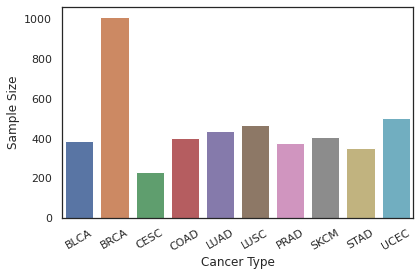

,Cancer Type,Sample Size
0,BLCA,384
1,BRCA,1011
2,CESC,231
3,COAD,400
4,LUAD,434
5,LUSC,467
6,PRAD,378
7,SKCM,405
8,STAD,350
9,UCEC,500


In [6]:
# Read slide representations.
type_composition = 'clr'
min_tiles        = 100

complete_path            = os.path.join(representations_path, '%s_%s_%s_mintiles_%s.csv' % (file_name, meta_folder, type_composition, min_tiles))
if h5_additional_path is not None:
    additional_complete_path = os.path.join(representations_path, '%s_%s_%s_mintiles_%s.csv' % (file_additional, meta_folder, type_composition, min_tiles))

do_read = False
if os.path.isfile(complete_path):
    complete_df_clr = pd.read_csv(complete_path)
    features = [column for column in complete_df_clr.columns if column != 'samples' and column != 'slides' and column != meta_field]
    if h5_additional_path is not None:
        if os.path.isfile(additional_complete_path):
            additional_complete_df_clr = pd.read_csv(additional_complete_path)
        else:
            do_read = True
else:
    do_read = True

if do_read:
    all_data = build_cohort_representations(meta_folder, meta_field, matching_field, groupby, fold_number, folds_pickle, h5_complete_path, h5_additional_path,
                                            type_composition=type_composition, min_tiles=min_tiles, use_conn=False, use_ratio=False, top_variance_feat=0, reduction=2)
    complete_df_clr, additional_complete_df_clr, frame_clusters, frame_samples, features = all_data
complete_df_clr.columns = complete_df_clr.columns.astype(str)

# Read tile vector representations.
folds = load_existing_split(folds_pickle)
fold = folds[fold_number]
dataframes, complete_df, leiden_clusters = read_csvs(adatas_path, matching_field, groupby, fold_number, fold, h5_complete_path, h5_additional_path, additional_as_fold=False, force_fold=fold_number)

mapping_pancan = complete_df[[meta_field, 'patterns']].drop_duplicates().reset_index()
mapping_pancan[meta_field] = mapping_pancan[meta_field].astype(int)
mapping_dict = dict()
remapping_dict = dict()
for i in range(mapping_pancan.shape[0]):
    mapping_dict[mapping_pancan.loc[i,'labels']]     = mapping_pancan.loc[i,'patterns']
    remapping_dict[mapping_pancan.loc[i,'patterns']] = mapping_pancan.loc[i,'labels']

# Visualize sample size per cancer type.
data_vis = list()
for lab, count in zip(*np.unique(complete_df_clr[1:][meta_field], return_counts=True)):
    data_vis.append((lab,count))
data_vis = pd.DataFrame(data_vis, columns=['Cancer Type', 'Sample Size'])
data_vis['Cancer Type'] = data_vis['Cancer Type'].replace(mapping_dict)
sns.set_theme(style='white')
sns.barplot(data=data_vis, x='Cancer Type', y='Sample Size')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
data_vis


# Survival Data

In [ ]:
event_ind_field  = 'os_event_ind'
event_data_field = 'os_event_data'

cancer_types = np.unique(data_vis['Cancer Type'].values.astype(str)).tolist()

# Pan-cancer survival data.
all_surv_df = list()
for cancer_type in cancer_types:
    if 'PRAD'==cancer_type: continue
    survival_csv = '%s/utilities/files/%s/overall_survival_TCGA_folds.csv' % (main_path, cancer_type)
    survival_df  = pd.read_csv(survival_csv)
    survival_df['Cancer Type'] = cancer_type
    all_surv_df.append(survival_df)
all_surv_df = pd.concat(all_surv_df, axis=0)
# Merge survival data with representations.
complete_surv_df  = complete_df_clr.merge(all_surv_df, how='inner', on='samples')

# Read 5-fold cross-validation.
folds_dict = OrderedDict()
for cancer_type in cancer_types:
    if 'PRAD'==cancer_type: continue
    survival_pkl = '%s/utilities/files/%s/overall_survival_TCGA_folds.pkl' % (main_path, cancer_type)
    if os.path.isfile(survival_pkl):
        folds = load_existing_split(survival_pkl)
        folds_dict[cancer_type] = folds


# Immune Lanscape Signatures - Spearman correlation

In [ ]:
meta_field        = 'labels'
matching_field    = 'samples'
corr_method      = 'spearman'
method_comb_pval = 'fisher'
type_integration = 'mean'
pval_th          = 0.01
th_corr          = 0
remove_nan       = True

# All Pan-Cancer combinations.
corr_dict, data_all, labels_allann, labels_unique = correlations_across_types(complete_surv_df[[matching_field, meta_field]+leiden_clusters.astype(str).tolist()], immune_landscape_df, meta_field, groupby, fold_number, pval_th,
                                                                              matching_field=matching_field, corr_method=corr_method, method_comb_pval=method_comb_pval,
                                                                              type_integration=type_integration, th_corr=th_corr, remove_nan=remove_nan,
                                                                              directory=correlations_path, file_name=file_name)
data_all['Cancer Type'] = data_all['Cancer Type'].astype(int).replace(mapping_dict)


In [ ]:
# Figure detail parameters.
cellSizePixels_x  = 105
cellSizePixels_y  = 110
dendrogram_ratio  = (0.05, 0.2)
fontsize_ticks    = 60
fontsize_labels   = 70
fontsize_annot    = 45
p_th              = 0.05
linewidths        = 7

x_label = 'Histomorphological Phenotype Cluster (HPC)'

# Cancer-Type Blind Results.
# g = fixedWidthClusterMap(dataFrame=corr_dict['blind'][0], mask=corr_dict['blind'][-1].values, x_label=x_label, y_label='Immune feature', p_th=p_th, fmt='.1f',
                        #  fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                        #  cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=0.2, linewidths=linewidths)
# immune_linkage_clr = copy.deepcopy(g.dendrogram_col.linkage)

# Per Cancer-Type Results.
keep_th = int(len(leiden_clusters)*0.4)
data_corr, mask_corr = keep_features_min_corr(mask=corr_dict['all'][-1], data=corr_dict['all'][0], keep_th=keep_th)
g = fixedWidthClusterMap(dataFrame=data_corr, mask=mask_corr, x_label=x_label, y_label='Immune feature', 
                        cox_os_clusters=None, cox_pfs_clusters=None, immune_hot_clusters=None, p_th=p_th, fmt='.1f', 
                        fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, 
                        dendrogram_ratio=dendrogram_ratio, cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, 
                        offset_col_color=0, resize_col_den=0.5, linewidths=linewidths, row_cluster=True, col_cluster=True)
                        # col_linkage=immune_linkage_clr_all)
immune_linkage_clr_all = copy.deepcopy(g.dendrogram_col.linkage)
plt.show()

file_path = os.path.join(correlations_path, file_name + '_immune_all_dendrogram.pkl')
with open(file_path, 'wb') as file:
    pickle.dump(immune_linkage_clr_all, file)


# Figure 10 Immune signatures.
ann_to_display = ['TIL Regional Fraction', 'Lymphocyte Infiltration Signature Score', 'Leukocyte Fraction', 'Stromal Fraction', 'Macrophage Regulation',
                  'Proliferation', 'Wound Healing', 'IFN-gamma Response', 'TGF-beta Response', 'T Cells CD8']
# Figure 8 Immune signatures.
ann_to_display = ['TIL Regional Fraction', 'Leukocyte Fraction', 'Stromal Fraction', 'Macrophage Regulation',
                  'Proliferation', 'Wound Healing', 'IFN-gamma Response', 'TGF-beta Response']

# Figure 4 Immune signatures.
ann_to_display = ['TIL Regional Fraction', 'Macrophage Regulation', 'Proliferation', 'TGF-beta Response']

cancer_mix           = 'all'
data_plot            = data_all[data_all['Type']==cancer_mix]
data_plot_ann        = data_plot[data_plot['Immune Signature'].isin(ann_to_display)]
data_plot_ann['HPC'] = data_plot_ann['HPC'].astype(str)
data_plot_ann        = data_plot_ann.sort_values(by=['Rho Combined', 'Sample Size'], ascending=False)

p = relplot_figure(data=data_plot_ann, y='Rho', x='HPC', hue='Cancer Type', col_wrap=2, col='Immune Signature', col_order=ann_to_display, size='Sample Size', pval_th=pval_th,
                   sizes=(30, 150), height=3, aspect=3.5, facet_kws={'sharex': False, 'sharey': True})

legend_colors = dict()
for i, handle in enumerate(p._legend.legendHandles):
    text = handle._label
    if text not in np.unique(data_plot_ann['Cancer Type']): continue
    legend_colors[text]= handle._hatch_color


# C-Index per HPC

In [ ]:
def train_model(hpc, matching_field, event_ind_field, event_data_field, dataframe, fold, model, use_fold=True, penalizer=0.0, l1_ratio=0.0):
    train_set, valid_set, test_set = fold

    train_df = dataframe[dataframe[matching_field].isin(train_set)]
    test_df  = dataframe[dataframe[matching_field].isin(test_set)]
    coef     = 1
    if model=='cox':
        cph = CoxPHFitter(penalizer=penalizer, l1_ratio=l1_ratio)
        if not use_fold:
            cph.fit(dataframe[[event_ind_field,event_data_field, str(hpc)]], duration_col=event_data_field, event_col=event_ind_field, show_progress=False, robust=True)
            dataframe.insert(loc=0, column='hazard', value=cph.predict_partial_hazard(dataframe[[event_ind_field,event_data_field, str(hpc)]]))
            median_cutoff = dataframe['hazard'].median()
            frame_return = dataframe
            coef = cph.summary['coef'].values[0]
        else:
            cph.fit(train_df[[event_ind_field,event_data_field, str(hpc)]], duration_col=event_data_field, event_col=event_ind_field, show_progress=False, robust=True)
            train_df.insert(loc=0, column='hazard', value=cph.predict_partial_hazard(train_df[[event_ind_field,event_data_field, str(hpc)]]))
            test_df.insert(loc=0,  column='hazard', value=cph.predict_partial_hazard(test_df[[event_ind_field,event_data_field, str(hpc)]]))
            median_cutoff = train_df['hazard'].median()
            frame_return = test_df
            coef = cph.summary['coef'].values[0]
    elif model=='hpc':
        if not use_fold:
            dataframe.insert(loc=0, column='hazard', value=dataframe[str(hpc)].values)
            median_cutoff = dataframe['hazard'].median()
            frame_return = dataframe
        else:
            train_df.insert(loc=0, column='hazard', value=train_df[str(hpc)].values)
            test_df.insert(loc=0,  column='hazard', value=test_df[str(hpc)].values)
            median_cutoff = train_df['hazard'].median()
            frame_return = test_df
    else:
        print('Not contemplated option', model)
        return

    return frame_return, median_cutoff, coef
    
def evaluation_and_riskgroups(evaluation_df, median_cutoff, risk_groups, event_data_field, event_ind_field):
    c_index    = np.round(concordance_index_censored(evaluation_df[event_ind_field]==1.0, evaluation_df[event_data_field], evaluation_df['hazard'])[0], 3)
    high_risk = evaluation_df[evaluation_df['hazard'].values>median_cutoff]
    low_risk  = evaluation_df[evaluation_df['hazard'].values<=median_cutoff]
    risk_groups[1] = risk_groups[1].append(high_risk, ignore_index=True)
    risk_groups[0] = risk_groups[0].append(low_risk, ignore_index=True)
    return c_index, risk_groups


In [ ]:
use_fold = True
model    = 'hpc'

ci_data       = list()
c_indexes_u   = list()
c_indexes_ci  = list()
p_values      = list()
coefs_u       = list()
coefs_ci      = list()
for cancer_type in folds_dict:
    cancer_cindexes_u   = list()
    cancer_cindexes_ci  = list()
    cancer_pvalues      = list()
    cancer_coef_u       = list()
    cancer_coef_ci      = list()
    folds_type          = folds_dict[cancer_type]
    for hpc in leiden_clusters:
        subset_df  = complete_surv_df[complete_surv_df['Cancer Type']==cancer_type]
        subset_df  = subset_df[[matching_field, str(hpc), event_ind_field, event_data_field]]
        
        folds_cindex         = list()
        folds_coef           = list()
        risk_groups          = [pd.DataFrame(), pd.DataFrame()]
        for i, fold in enumerate(folds_type):
            evaluation_df, median_cutoff, coef = train_model(hpc, matching_field, event_ind_field, event_data_field, subset_df, fold, model, use_fold=use_fold, penalizer=10.0, l1_ratio=0.0)
            c_index, risk_groups = evaluation_and_riskgroups(evaluation_df, median_cutoff, risk_groups, event_data_field, event_ind_field)
            folds_cindex.append(c_index)
            folds_coef.append(coef)
            if not use_fold:
                break
            
        # calculate split and p-value.
        c_index_u  = np.round(np.mean(folds_cindex),3)
        mean, minus, plus = mean_confidence_interval(folds_cindex, confidence=0.95)
        c_index_ci = np.round(plus-mean,3)

        coef_u     = np.round(np.mean(folds_coef),3)
        c_mean, c_minus, c_plus = mean_confidence_interval(folds_cindex, confidence=0.95)
        coef_ci    = np.round(c_plus-c_mean,3)
        
        high_risk = risk_groups[1]
        low_risk  = risk_groups[0]
        p_value   = np.round(logrank_test(high_risk[event_data_field].astype(float), low_risk[event_data_field].astype(float), event_observed_A=high_risk[event_ind_field].astype(float), event_observed_B=low_risk[event_ind_field].astype(float)).p_value, 3)
        ci_data.append((cancer_type, hpc, c_index_u, c_index_ci, p_value))
        cancer_cindexes_u.append(c_index_u)
        cancer_cindexes_ci.append(c_index_ci)
        cancer_pvalues.append(p_value)
        cancer_coef_u.append(coef_u)
        cancer_coef_ci.append(coef_ci)
    c_indexes_u.append(cancer_cindexes_u)
    c_indexes_ci.append(cancer_cindexes_ci)
    p_values.append(cancer_pvalues)
    coefs_u.append(cancer_coef_u)
    coefs_ci.append(cancer_coef_ci)

# P Value for visualization.
ci_data = pd.DataFrame(ci_data, columns=['Cancer Type', 'HPC', 'C-Index Mean', 'C-Index 95CI', 'P-Value'])
ci_data['P-Value-Minus'] = -ci_data['P-Value'].values

# DataFrames for clusterplot.
c_indexes_u = pd.DataFrame(c_indexes_u, columns=leiden_clusters)
c_indexes_u.index = folds_dict.keys()
c_indexes_ci = pd.DataFrame(c_indexes_ci, columns=leiden_clusters)
c_indexes_ci.index = folds_dict.keys()

p_values = pd.DataFrame(p_values, columns=leiden_clusters)
p_values.index = folds_dict.keys()

coefs_u = pd.DataFrame(coefs_u, columns=leiden_clusters)
coefs_u.index = folds_dict.keys()
coefs_ci = pd.DataFrame(coefs_ci, columns=leiden_clusters)
coefs_ci.index = folds_dict.keys()


if use_fold:
    name_fold = '5fold'
else:
    name_fold = 'Nofold'

run_name = '%s_%s' % (model, name_fold)
print(run_name)

In [ ]:
x_label = 'Histomorphological Phenotype Cluster (HPC)'
y_label = 'Cancer Type'
cellSizePixels_x  = 130
cellSizePixels_y  = 110
dendrogram_ratio  = (0.05, 0.2)
fontsize_ticks    = 60
fontsize_labels   = 70
fontsize_annot    = 45
linewidths        = 7

p_th = 0.05
c_i  = 0.50
c_indexes_vis = c_indexes_u
p_values_vis  = p_values
mask_vis      = p_values_vis > p_th
g = fixedWidthClusterMap(dataFrame=c_indexes_vis, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                         fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                         cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.3, linewidths=linewidths, 
                         row_cluster=False, col_cluster=False)
figure_name = '%s_mean_nolinkage.png' % run_name
print(figure_name)
plt.show()

if use_fold:
    c_i  = 0.0
    c_indexes_vis = c_indexes_ci
    g = fixedWidthClusterMap(dataFrame=c_indexes_vis, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                            fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                            cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.3, linewidths=linewidths,
                            row_cluster=False, col_cluster=False)
    figure_name = '%s_ci_nolinkage.png' % run_name
    print(figure_name)
    plt.show()


In [ ]:
x_label = 'Histomorphological Phenotype Cluster (HPC)'
y_label = 'Cancer Type'
cellSizePixels_x  = 130
cellSizePixels_y  = 110
dendrogram_ratio  = (0.05, 0.2)
fontsize_ticks    = 60
fontsize_labels   = 70
fontsize_annot    = 45
linewidths        = 7

p_th = 0.05
c_i  = 0.50
c_indexes_vis = c_indexes_u
p_values_vis  = p_values
mask_vis      = p_values_vis > p_th
g = fixedWidthClusterMap(dataFrame=c_indexes_vis, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                         fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                         cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.3, linewidths=linewidths, 
                         row_cluster=True, col_cluster=True)
col_dendrogram = g.dendrogram_col.linkage
row_dendrogram = g.dendrogram_row .linkage
figure_name = '%s_mean.png' % run_name
print(figure_name)
plt.show()

if use_fold:
    c_i  = 0.0
    c_indexes_vis = c_indexes_ci
    g = fixedWidthClusterMap(dataFrame=c_indexes_vis, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                            fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                            cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.3, linewidths=linewidths,
                            col_linkage=col_dendrogram, row_linkage=row_dendrogram, row_cluster=True, col_cluster=True)
    figure_name = '%s_ci.png' % run_name
    print(figure_name)
    plt.show()


In [ ]:
p_th = 0.05
c_i  = 0.50
c_indexes_vis = c_indexes_u
p_values_vis  = p_values
mask_vis      = p_values_vis > p_th
g = fixedWidthClusterMap(dataFrame=c_indexes_vis, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                         fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                         cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.3, linewidths=linewidths,
                         col_linkage=immune_linkage_clr_all)
row_dendrogram = g.dendrogram_row .linkage
figure_name = '%s_mean_x_immune.png' % run_name
print(figure_name)
plt.show()

In [ ]:
# Figure detail parameters.
x_label = 'Histomorphological Phenotype Cluster (HPC)'
y_label = 'Cancer Type'
cellSizePixels_x  = 130
cellSizePixels_y  = 110
dendrogram_ratio  = (0.05, 0.2)
fontsize_ticks    = 80
fontsize_labels   = 90
fontsize_annot    = 45
linewidths        = 7


p_th = 0.05
c_i  = 0.50
c_indexes_vis = c_indexes_u
p_values_vis  = p_values
mask_vis      = p_values_vis > p_th
g = fixedWidthClusterMap(dataFrame=c_indexes_vis, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                         fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                         cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.3, linewidths=linewidths,
                         col_linkage=immune_linkage_clr_all)
row_dendrogram = g.dendrogram_row .linkage
figure_name = '%s_mean_x_immune.png' % run_name
print(figure_name)
plt.show()

if use_fold:
    p_th = 0.05
    c_i  = 0.0
    c_indexes_vis = c_indexes_ci
    g = fixedWidthClusterMap(dataFrame=c_indexes_vis, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                            fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                            cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.4, linewidths=linewidths,
                            col_linkage=immune_linkage_clr_all, row_linkage=row_dendrogram)
    figure_name = '%s_ci_x_immune.png' % run_name
    print(figure_name)
    plt.show()

if model=='cox':
    coef_i = 0.0
    g = fixedWidthClusterMap(dataFrame=coefs_u, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.3f', vcenter=coef_i,
                         fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                         cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=1.3, linewidths=linewidths,
                         col_linkage=immune_linkage_clr_all, row_linkage=row_dendrogram)
    figure_name = '%s_coef_mean_x_immune.png' % run_name
    print(figure_name)
    plt.show()

    if use_fold:
        p_th = 0.05
        c_i  = 0.0
        g = fixedWidthClusterMap(dataFrame=coefs_ci, mask=mask_vis, x_label=x_label, y_label=y_label, p_th=p_th, fmt='.2f', vcenter=c_i,
                                fontsize_ticks=fontsize_ticks, fontsize_labels=fontsize_labels, fontsize_annot=fontsize_annot, dendrogram_ratio=dendrogram_ratio,
                                cellSizePixels_x=cellSizePixels_x, cellSizePixels_y=cellSizePixels_y, offset_col_color=0, resize_col_den=2., linewidths=linewidths,
                                col_linkage=immune_linkage_clr_all, row_linkage=row_dendrogram)
        figure_name = '%s_coef_ci_x_immune.png' % run_name
        print(figure_name)
        plt.show()

In [ ]:
def get_subsample_legend(size_field, handles, labels, number_hue=5, number_size=10):
    def get_subsample_ind(indexes, number=5):
        ind = int(np.ceil((len(indexes)/(number-1))))
        indexes_sub = indexes[::ind]
        if len(indexes_sub) != 5 and indexes_sub[-1]!=indexes[-1]:
            indexes_sub.append(indexes[-1])
        elif len(indexes_sub) == 5 and indexes_sub[-1]!=indexes[-1]:
            indexes_sub[-1] = indexes[-1]
        return indexes_sub

    # Get end and start of hue and size.
    end_hue = np.argwhere(np.array(labels)==size_field)[0,0]-1
    start_size = end_hue + 2
    # List of indexes.
    hue_idx  = list(range(1,end_hue+1,1))
    size_idx = list(range(start_size,len(labels),1))
    # Get a subset of indexes.
    hue_sub  = [0] + get_subsample_ind(hue_idx, number=number_hue)
    size_sub = [start_size-1] + get_subsample_ind(size_idx, number=number_size)

    # final set of handles and labels
    size_label_sub = [labels[size_sub[0]].split('-Minus')[0]] + [label[1:] for label in np.array(labels)[size_sub[1:]].tolist()]
    labels_sub  = np.array(labels)[hue_sub].tolist() + size_label_sub
    handles_sub = [handles[ind] for ind in hue_sub+size_sub]

    if float(labels_sub[-1]) == 0.0:
        labels_sub.pop()
        handles_sub.pop()

    return handles_sub, labels_sub

cmap = sns.diverging_palette(250, 20, as_cmap=True)

hue  = 'C-Index Mean'
size = 'P-Value-Minus'
p_th = 0.05
c_i  = 0.50

ci_data_vis = ci_data

hue_norm  = TwoSlopeNorm(vmin=ci_data_vis[hue].min(),  vcenter=c_i,   vmax=ci_data_vis[hue].max())
size_norm = TwoSlopeNorm(vmin=ci_data_vis[size].min(), vcenter=-p_th, vmax=ci_data_vis[size].max())

fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(1, 2, 1)
grid = sns.scatterplot(data=ci_data_vis, y='Cancer Type', x='HPC', size=size, hue=hue, hue_norm=hue_norm, size_norm=size_norm, palette=cmap, sizes=(10, 200), ax=ax, legend='full')
ax.set_xticks(leiden_clusters, labels=leiden_clusters)
handles, labels = grid._axes.get_legend_handles_labels()
handles_sub, labels_sub = get_subsample_legend(size_field=size, handles=handles, labels=labels, number_hue=10, number_size=15)
grid.legend_.remove()
legend = plt.legend(handles_sub,labels_sub, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontweight('bold')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)

ax.xaxis.get_label().set_fontweight('bold')
ax.yaxis.get_label().set_fontweight('bold')

legend.get_title().set_weight('bold')
[leg_text.set_weight('bold') for leg_text in legend.get_texts()]

plt.show()

# HPCs Generalization Patients & Institutions

In [ ]:
# Concatenate all data.
tiles_df = pd.concat([dataframes[0], dataframes[1], dataframes[2]])
tiles_df['samples']  = tiles_df['slides'].apply(lambda x: '-'.join(x.split('-')[:3]))
tiles_df['TSS Code'] = tiles_df['samples'].apply(lambda x: x.split('-')[1]).values.astype(str)

# Include counts per samples and HPC
for name, field in [('sample',matching_field), ('hpc', groupby)]:
    counts_per_field = tiles_df.groupby(field).count()
    counts_per_field = counts_per_field.reset_index()
    counts_per_field = counts_per_field.rename(columns={'tiles':'nt_per_%s'%name})
    tiles_df = tiles_df.merge(counts_per_field[[field, 'nt_per_%s'%name]], on=field)

# Normalized values of percentage of total tiles in HPC
tiles_df.insert(loc=len(tiles_df.columns), column='nt_per_hpc_norm', value=tiles_df['nt_per_hpc'].values/tiles_df.shape[0])

# Normalize contribution of HPC in patient.
hpc_pat = tiles_df[[matching_field, groupby, 'tiles']].groupby([matching_field, groupby]).count()
hpc_pat = hpc_pat.reset_index()
hpc_pat = hpc_pat.rename(columns={'tiles':'nt_per_sample_hpc'})
hpc_pat = hpc_pat.merge(tiles_df[[matching_field, 'nt_per_sample']].drop_duplicates(), on=matching_field)
hpc_pat = hpc_pat.drop_duplicates()
hpc_pat['nt_per_sample_hpc_norm'] = np.divide(hpc_pat['nt_per_sample_hpc'].values.astype(float), hpc_pat['nt_per_sample'].values.astype(float))


In [ ]:
# Visualize Median and Mean.
fig = plt.figure(figsize=(40,10))
ax = fig.add_subplot(1, 1, 1)
sns.pointplot(data=hpc_pat, x=groupby, y='nt_per_sample_hpc_norm', ci=99.9, join=False, color='blue', scale=1.5, markers='s', ax=ax)
sns.pointplot(data=hpc_pat, x=groupby, y='nt_per_sample_hpc_norm', estimator=np.median, ci=99.9, join=False, color='red', scale=1.5, markers='s', ax=ax)
ax.set_title('Mean and 95 Confidence Interval for all patients\npercetage of total tissue area per patient')
ax.axhline(1/len(leiden_clusters))
ax.axhline(0.02)
plt.show()

# Distribution of percentage of HPC per patient.
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(2, 1, 1)
sns.violinplot(data=hpc_pat, x=groupby, y='nt_per_sample_hpc_norm', scale='count', ax=ax)
ax.set_title('Distribution of percetage of total tissue area per patient')
ax.set_ylim([-0.05,0.6])
ax = fig.add_subplot(2, 1, 2)
sns.boxplot(data=hpc_pat, x=groupby, y='nt_per_sample_hpc_norm', fliersize=2, whis=1., flierprops={"marker": "x"}, ax=ax)
ax.set_title('Distribution of percetage of total tissue area per patient')
ax.set_ylim([-0.05,0.6])
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
pal = sns.cubehelix_palette(len(leiden_clusters), rot=-.25, light=.7)
for hpc in reversed(leiden_clusters):
    sns.kdeplot(hpc_pat[hpc_pat[groupby]==hpc]['nt_per_sample_hpc_norm'].values, ax=ax, cut=0, color=pal[hpc])
    ax.axvline(np.median(hpc_pat[hpc_pat[groupby]==hpc]['nt_per_sample_hpc_norm'].values))
ax.axvline(1/len(leiden_clusters), color='black')
ax.axvline(0, color='black')
ax.set_xlim([-.005,0.175])
ax.set_xlim([-.005,0.1])
plt.show()

In [ ]:
threshold = 0.01
hpc_pat_th = hpc_pat[hpc_pat.nt_per_sample_hpc_norm >= threshold]
hpc_pat_th = hpc_pat_th.groupby([groupby]).count()['samples']/len(np.unique(hpc_pat[matching_field]))
hpc_pat_th = hpc_pat_th.reset_index()
hpc_pat_th = hpc_pat_th.rename(columns={groupby:'HPC'})

plot_institution_distribution(hpc_pat_th, field='samples', title='Percentage of total patients\npresent in the HPC', figsize=(30,7), fontsize_labels=22, fontsize_legend=20)

In [ ]:
tiles_df = pd.concat([dataframes[0], dataframes[1], dataframes[2]])
tiles_df['TSS Code'] = tiles_df['samples'].apply(lambda x: x.split('-')[1]).values.astype(str)
tss_hpc = tiles_df[['TSS Code', 'tiles']].groupby('TSS Code').count()
tss_hpc = tss_hpc.reset_index()
tss_hpc = tss_hpc.rename(columns={'tiles':'total_tiles'})

data_hpc_inst = list()
total_institutions = np.unique(tiles_df['TSS Code'].values)
total_patients     = np.unique(tiles_df[matching_field].values)
for hpc in np.unique(tiles_df[groupby]):
    hpc_df    = tiles_df[tiles_df[groupby]==hpc]
    patients  = np.unique(hpc_df[matching_field].values)
    hpc_df    = hpc_df.groupby('TSS Code').count()
    hpc_df    = hpc_df.reset_index()[['TSS Code', 'tiles']]
    hpc_df    = hpc_df.merge(tss_hpc, on='TSS Code', how='inner')
    hpc_df.insert(len(hpc_df.columns), 'tiles_norm', np.divide(hpc_df['tiles'].values,hpc_df['total_tiles'].values))
    hpc_df    = hpc_df[hpc_df['tiles_norm']>=threshold]
    data_hpc_inst.append((hpc, hpc_df.shape[0]/tss_hpc.shape[0], len(patients)/len(total_patients)))
data_hpc_inst = pd.DataFrame(data_hpc_inst, columns=['HPC', 'Percentage of Institutions in HPC', 'Percentage of All Patients in HPC'])

plot_institution_distribution(data_hpc_inst, field='Percentage of Institutions in HPC', title='Percentage of total institutions\npresent in the HPC', figsize=(30,7), fontsize_labels=22, fontsize_legend=20)

In [ ]:
def plot_institution_distribution_ax(data_hpc_inst, field, title, ax, fontsize_labels=22, fontsize_legend=20, show_max_min=False):
    def colors_from_values(values, palette_name, normalize=False):
        # normalize the values to range [0, 1]
        if normalize:
            normalized = (values - min(values)) / (max(values) - min(values))
        else:
            normalized = values
        # convert to indices
        indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
        # use the indices to get the colors
        palette = sns.color_palette(palette_name, int(1.5*len(values)))
        return np.array(palette).take(indices, axis=0)

    y = data_hpc_inst[field].values
    sns.barplot(data=data_hpc_inst, x='HPC', y=field, palette=colors_from_values(y, "Greens_d"), ax=ax)

    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0.0,1.0])
    yticks = (np.array(range(0,11,1))/10).tolist()
    ax.set_yticks(yticks, yticks)

    ax.set_title(title,  fontsize=fontsize_labels*1.3, fontweight='bold')
    ax.set_xlabel('\nHistomorphological Phenotype Cluster (HPC)', fontsize=fontsize_labels,     fontweight='bold')
    ax.set_ylabel(' ', fontsize=fontsize_labels, fontweight='bold')
    if show_max_min:
        max_val = np.max(data_hpc_inst[field].values)
        min_val = np.min(data_hpc_inst[field].values)
        ax.axhline(max_val, linestyle='--')
        ax.axhline(min_val, linestyle='--')
    ax.axhline(0.50, linestyle='--', color='black')
    ax.axhline(0.25, linestyle='--', color='black')

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_labels)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_labels)
        tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    
number_res = 7
fig   = plt.figure(figsize=(30,7*number_res))
for i in range(number_res):
    ax    = fig.add_subplot(number_res, 1, i+1)
    plot_institution_distribution_ax(data_hpc_inst, field='Percentage of Institutions in HPC', title='Percentage of total institutions\npresent in the HPC', ax=ax, fontsize_labels=22, fontsize_legend=20)
plt.tight_layout()
print(main_cluster_path)
plt.savefig(os.path.join(main_cluster_path, 'cluster_evalutation_institution_distribution.jpg'))
plt.show()

# Cluster Network

In [ ]:
done = False
if os.path.isfile(h5ad_path.replace('.h5ad', '_paga.h5ad')):
    done=True
    adata_train = anndata.read_h5ad(h5ad_path.replace('.h5ad', '_paga.h5ad'))
else:
    sc.tl.paga(adata_train, groups=groupby, neighbors_key='nn_leiden')

In [ ]:
# Graph visualization related
# This next variable can be modified so it more clearly shows the cluster network
# Layout corresponds to the technique for the cluster network layout.
# Threshold corresponds to threshold for the edge connection between nodes, higher values keep only stronger bonds.
layout           = 'fa'  # ‘fa’, ‘fr’, ‘rt’, ‘rt_circular’, ‘drl’, ‘eq_tree’
random_state     = 3
threshold        = 0.75

# Figure related
node_size_scale  = 5
node_size_power  = 0.5
edge_width_scale = .01
fontsize         = 10
fontoutline      = 2

sns.set_theme(style='white')
fig = plt.figure(figsize=(100,10))
ax  = fig.add_subplot(1, 3, 1)
sc.pl.paga(adata_train, layout=layout, random_state=random_state, color=meta_field, threshold=threshold, node_size_scale=node_size_scale, node_size_power=node_size_power,
           edge_width_scale=edge_width_scale, fontsize=fontsize, fontoutline=fontoutline, frameon=False, show=False, ax=ax)
plt.show()

# UMAP - PAGA Leiden based

In [ ]:
if not done:
    sc.tl.umap(adata_train, init_pos="paga", neighbors_key='nn_leiden')
    adata_train.write(h5ad_path.replace('.h5ad', '_paga.h5ad'))


In [ ]:
meta_field        = 'labels'
matching_field    = 'samples'
corr_method      = 'spearman'
method_comb_pval = 'fisher'
type_integration = 'mean'
pval_th          = 0.01
th_corr          = 0
remove_nan       = True

# Remove cancer types.
data_frame_to_use = complete_df_clr.copy(deep=True)

# All Pan-Cancer subset.
corr_dict, data_all, labels_allann, labels_unique = correlations_across_types(data_frame_to_use, immune_landscape_df, meta_field, groupby, fold_number, pval_th,
                                                                              matching_field=matching_field, corr_method=corr_method, method_comb_pval=method_comb_pval,
                                                                              type_integration=type_integration, th_corr=th_corr, remove_nan=remove_nan,
                                                                              directory=correlations_path, file_name=file_name)
data_all['Cancer Type'] = data_all['Cancer Type'].astype(int).replace(mapping_dict)

all_data_rho_clr = corr_dict['all'][0]

In [ ]:
def fix_umap_annotations(ax1):
    # HPC 20
    old_x = ax1.texts[20]._x
    ax1.texts[20]._x = old_x*1.03

    # HPC 17
    old_y = ax1.texts[17]._y
    ax1.texts[17]._y = old_y*1.8
    # HPC 30
    old_y = ax1.texts[30]._y
    ax1.texts[30]._y = old_y*0.2

sns.set_theme(style='white')
fig = plt.figure(figsize=(10,10))

ax1  = fig.add_subplot(1, 1, 1)
colors = sns.color_palette('tab20', len(np.unique(adata_train.obs[groupby].values)))
ax1 = sc.pl.umap(adata_train, legend_fontsize=fontsize, legend_fontoutline=fontoutline, legend_loc='on data', frameon=False, show=False, ax=ax1, color=groupby, palette=colors, size=marker_size)
ax1.set_title('')

fix_umap_annotations(ax1=ax1)

plt.show()

In [ ]:
feature_1 = 'TIL Regional Fraction'
feature_2 = 'Proliferation'
feature_3 = 'TGF-beta Response'

# feature_1 = 'Macrophage Regulation'
# feature_2 = 'Wound Healing'
# feature_3 = 'Stromal Fraction'

adata_train.obs['Cancer Type'] = adata_train.obs['labels'].astype(float).replace(mapping_dict).values
adata_train.obs['samples']     = adata_train.obs['slides'].apply(lambda x: '-'.join(x.split('-')[:3]))
adata_train.obs['TSS Code']    = adata_train.obs['samples'].apply(lambda x: x.split('-')[1]).values.astype(str)
feat1_assignations = list()
feat2_assignations = list()
feat3_assignations = list()
for leiden_tile in adata_train.obs[groupby].values.astype(str):
    feat1_assignations.append(all_data_rho_clr.loc[feature_1,leiden_tile])
    feat2_assignations.append(all_data_rho_clr.loc[feature_2,leiden_tile])
    feat3_assignations.append(all_data_rho_clr.loc[feature_3,leiden_tile])
adata_train.obs[feature_1] = feat1_assignations
adata_train.obs[feature_2] = feat2_assignations
adata_train.obs[feature_3] = feat3_assignations

# Graph visualization related
layout           = 'fa'  # ‘fa’, ‘fr’, ‘rt’, ‘rt_circular’, ‘drl’, ‘eq_tree’
random_state     = 0
threshold        = 0.74

# Figure related
node_size_scale  = 7
node_size_power  = 0.5
edge_width_scale = .05
fontsize    = 15
fontoutline = 4
marker_size = 3
only_seleted = []


cmap = sns.diverging_palette(250, 20, as_cmap=True)

sns.set_theme(style='white')
fig = plt.figure(figsize=(30,10))

ax1  = fig.add_subplot(1, 3, 1)
colors = sns.color_palette('tab20', len(np.unique(adata_train.obs[groupby].values)))
ax1 = sc.pl.umap(adata_train, legend_fontsize=fontsize, legend_fontoutline=fontoutline, legend_loc='on data', frameon=False, show=False, ax=ax1, color=groupby, palette=colors, size=marker_size)
fix_umap_annotations(ax1=ax1)
prev_texts = ax1.texts


# Axes 2 - TIL Regional Fraction
vmax = np.max(adata_train.obs[feature_2].to_numpy())
vmin = np.min(adata_train.obs[feature_2].to_numpy())
if vmin != 0:
    vmin = -vmax
ax2  = fig.add_subplot(1, 3, 2)
ax2 = sc.pl.umap(adata_train, legend_fontsize=fontsize, legend_fontoutline=fontoutline, frameon=False, show=False, ax=ax2, color=feature_2, cmap=cmap, legend_loc=None, vmin=vmin, vmax=vmax, size=marker_size)
ax2.set_title(feature_2, fontweight='bold', fontsize=20)
cbar = ax2.collections[-1].colorbar
for a in prev_texts:
    ax2.annotate(a._text, xy=(a._x,a._y), color=a._color, verticalalignment=a._verticalalignment, horizontalalignment=a._horizontalalignment,
                 fontproperties=a._fontproperties, linespacing=a._linespacing, path_effects=a._path_effects)
# adjust_text(ax2.texts)
prev_texts = ax2.texts
# # Legend on side
cbar.ax.tick_params(labelsize=fontsize*0.9)
[label.set_fontweight('bold') for label in cbar.ax.get_yticklabels()]
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

# Axes 2 - Macrophage Regulation
vmax = np.max(adata_train.obs[feature_3].to_numpy())
vmin = np.min(adata_train.obs[feature_3].to_numpy())
if vmin != 0:
    vmin = -vmax

ax3  = fig.add_subplot(1, 3, 3)
ax3 = sc.pl.umap(adata_train, legend_fontsize=fontsize, legend_fontoutline=fontoutline, frameon=False, show=False, ax=ax3, color=feature_3, cmap=cmap, vmin=vmin, vmax=vmax, size=marker_size)
ax3.set_title(feature_3, fontweight='bold', fontsize=20)
cbar = ax3.collections[-1].colorbar
for a in prev_texts:
    ax3.annotate(a._text, xy=(a._x,a._y), color=a._color, verticalalignment=a._verticalalignment, horizontalalignment=a._horizontalalignment,
                 fontproperties=a._fontproperties, linespacing=a._linespacing, path_effects=a._path_effects)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

# # Legend on side
cbar.ax.tick_params(labelsize=fontsize*0.9)
[label.set_fontweight('bold') for label in cbar.ax.get_yticklabels()]

ax1.clear()

# Axes 1 - TIL Regional Fraction
vmax = np.max(adata_train.obs[feature_1].to_numpy())
vmin = np.min(adata_train.obs[feature_1].to_numpy())
if vmin != 0:
    vmin = -vmax
ax1 = sc.pl.umap(adata_train, legend_fontsize=fontsize, legend_fontoutline=fontoutline, frameon=False, show=False, ax=ax1, color=feature_1, cmap=cmap, legend_loc=None, vmin=vmin, vmax=vmax, size=marker_size)
ax1.set_title(feature_1, fontweight='bold', fontsize=20)
cbar = ax1.collections[-1].colorbar
for a in prev_texts:
    ax1.annotate(a._text, xy=(a._x,a._y), color=a._color, verticalalignment=a._verticalalignment, horizontalalignment=a._horizontalalignment,
                 fontproperties=a._fontproperties, linespacing=a._linespacing, path_effects=a._path_effects)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

# # Legend on side
cbar.ax.tick_params(labelsize=fontsize*0.9)
[label.set_fontweight('bold') for label in cbar.ax.get_yticklabels()]

plt.show()


In [ ]:
figsize = (15,7)

fontsize_labels = 25
fontsize_legend = 20
l_box_w         = 2

df_all = adata_train.obs.copy(deep=True)
df_all.insert(0, 'UMAP Dim. 1', adata_train.obsm['X_umap'][:,1])
df_all.insert(0, 'UMAP Dim. 0', adata_train.obsm['X_umap'][:,0])

sns.set_theme(style='white')
plot_umaps(data_df=df_all, x='UMAP Dim. 0', y='UMAP Dim. 1', hue='Cancer Type', scatter_size=5, palette='tab20', figsize=figsize, fontsize_labels=fontsize_labels,
           fontsize_legend=fontsize_legend, l_box_w=l_box_w)

plot_umaps(data_df=df_all, x='UMAP Dim. 0', y='UMAP Dim. 1', hue='TSS Code', scatter_size=1, palette='tab20_r', figsize=figsize, fontsize_labels=fontsize_labels,
           fontsize_legend=fontsize_legend, l_box_w=l_box_w)

plot_umaps(data_df=df_all, x='UMAP Dim. 0', y='UMAP Dim. 1', hue='TSS Code', scatter_size=1, palette='colorblind', figsize=figsize, fontsize_labels=fontsize_labels,
           fontsize_legend=fontsize_legend, l_box_w=l_box_w)


# HPC - Tile Samples

In [ ]:
def data_img(data):
    content = h5py.File(data.hdf5_path, 'r')
    frame = pd.DataFrame(range(data.images.shape[0]), columns=['indexes'])
    for key in content.keys():
        if 'slides' in key:
            frame['slides'] = content[key][:].astype(str)
        elif 'tiles' in key:
            frame['tiles'] = content[key][:].astype(str)
    return data.images, frame

images, frame_img = data_img(data=data.training)

tiles_df = pd.concat([dataframes[0], dataframes[1], dataframes[2]])
tiles_df = tiles_df.merge(frame_img, on=['slides','tiles'], how='inner')


In [ ]:
def cluster_set_images(review_clusters, frame, images, groupby, batches=1, ncols=20, nrows=4, annotated=None):
    for cluster_id in review_clusters:
        indexes       = frame[(frame[groupby]==cluster_id)]['indexes'].values.tolist()
        random.shuffle(indexes)
        combined_plot = sorted(indexes[:100*batches])

        csv_information = list()
        images_cluster = list()
        for index in combined_plot:
            images_cluster.append(images[int(index)]/255.)

        for batch in range(batches):
            fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
            fig.set_figheight(8)
            fig.set_figwidth(8*(ncols/4)*0.8)
            if annotated is not None:
                fig.suptitle('HPC %s - %s' % (cluster_id, annotated), ha='center', fontweight='bold', fontsize=65)
            else:
                fig.suptitle('HPC %s' % (cluster_id), ha='center', fontweight='bold', fontsize=65)
            gs = axs[0, -4].get_gridspec()
            # remove the underlying axes
            for i in range(ncols-4,ncols):
                for ax in axs[0:, i]:
                    ax.remove()
            axbig = fig.add_subplot(gs[0:, -4:])
            axbig.set_xticks([])
            axbig.set_yticks([])
            axbig.set_yticks([])
            axes_list = list(axs.flatten())
            axes_list.append(axbig)
            for ax, im in zip(axes_list, images_cluster[batch*100:(batch+1)*100]):
                ax.imshow(im)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_yticks([])
                for axis in ['top','bottom','left','right']:
                    ax.spines[axis].set_linewidth(4)
            plt.subplots_adjust(wspace=0.05, hspace=0.05)
            fig.tight_layout()
            plt.show()

def cluster_set_images_pertype(review_clusters, frame, images, groupby, batches=1, ncols=20, nrows=4, annotated=False, remove_type=None, legend_colors=None, wspace=0.1, figures_path=None):
    types = [type for type in np.unique(frame.patterns) if type not in remove_type]

    colors = sns.color_palette(legend_colors, len(types))

    figures_path = os.path.join(figures_path, 'cluster_samples')


    if figures_path is not None and not os.path.isdir(figures_path):
        os.makedirs(figures_path)

    indexes_dict = dict()
    for cluster_id in review_clusters:
        cluster_frame = frame[(frame[groupby]==cluster_id)]
        for type in types:
            indexes = cluster_frame[cluster_frame.patterns==type]['indexes_x'].values.tolist()
            random.shuffle(indexes)
            indexes_dict[type] = indexes
        
        for batch in range(batches):
            fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
            fig.set_figheight(8)
            fig.set_figwidth(8*(ncols/4)*0.6)
            if annotated:
                fig.suptitle('HPC %s' % (cluster_id), ha='center', fontweight='bold', fontsize=50)

            for i, type in enumerate(indexes_dict):
                axes_type = list()
                indexes_type = indexes_dict[type]
                column = 0
                cols_type = int(ncols/len(types))

                gs = axs[-1, 2*(i)].get_gridspec()
                axs[-1, 2*i].remove()
                axs[-2, 2*i].remove()
                axs[-1, 2*(i)+1].remove()
                axs[-2, 2*(i)+1].remove()
                axbig = fig.add_subplot(gs[-2:, 2*(i):2*(i)+2])
                axes_type.append(axbig)

                for column in range(cols_type):
                    for row in range(nrows-2):
                        ax = axs[row, i*cols_type + column]
                        axes_type.append(ax)

                for j, ax in enumerate(axes_type):
                    index = indexes_type[batch*len(axes_type)+j]
                    im    = images[int(index)]/255.
                    ax.imshow(im)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.set_yticks([])
                    for axis in ['top','bottom','left','right']:
                        ax.spines[axis].set_linewidth(4)
                        ax.spines[axis].set_color(colors[i])
                    if j == 0:
                        ax.set_xlabel(type, fontsize=26, fontweight='bold')
                        ax.xaxis.set_label_coords(.5, -.1)

            plt.subplots_adjust(wspace=wspace, hspace=0.1)
            fig.tight_layout()
            if figures_path is not None:
                plt.savefig(os.path.join(figures_path, 'HPC_%s_batch%s.jpg' % (cluster_id, batch)), dpi=500)
                plt.close()
            else:
                plt.show()

In [ ]:
cluster_set_images_pertype(review_clusters=leiden_clusters, frame=tiles_df, images=images, groupby=groupby, batches=2, ncols=20, nrows=6, annotated=True, remove_type=list(),
                           legend_colors='tab10', wspace=0.05, figures_path=figures_path)

In [ ]:
cluster_id = 1
cluster_frame = frame[(frame[groupby]==cluster_id)]
types = [type for type in np.unique(cluster_frame.patterns) if type not in remove_type]
for type in types:
    type_df = cluster_frame[cluster_frame.patterns==type]
    cluster_set_images(review_clusters=[1], frame=type_df, images=images, groupby=groupby, batches=2, ncols=20, nrows=4, annotated=type)